In [211]:
# !pip install kaggle

In [212]:
# from google.colab import files
# files.upload()

In [213]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

In [214]:
# !kaggle datasets download -d census/business-and-industry-reports

In [215]:
# !kaggle datasets download -d jsphyg/weather-dataset-rattle-package

In [216]:
# from zipfile import ZipFile
# file_name = "weather.zip"

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print("Success")

In [217]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [218]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [219]:
dfs = df.groupby('Location')['Date'].nunique()

print(dfs)

Location
Adelaide            3090
Albany              3016
Albury              3011
AliceSprings        3031
BadgerysCreek       2928
Ballarat            3028
Bendigo             3034
Brisbane            3161
Cairns              2988
Canberra            3418
Cobar               2988
CoffsHarbour        2953
Dartmoor            2943
Darwin              3192
GoldCoast           2980
Hobart              3188
Katherine           1559
Launceston          3028
Melbourne           2435
MelbourneAirport    3009
Mildura             3007
Moree               2854
MountGambier        3030
MountGinini         2907
Newcastle           2955
Nhil                1569
NorahHead           2929
NorfolkIsland       2964
Nuriootpa           3002
PearceRAAF          2762
Penrith             2964
Perth               3193
PerthAirport        3009
Portland            2996
Richmond            2951
Sale                3000
SalmonGums          2955
Sydney              3337
SydneyAirport       3005
Townsville      

In [220]:
df = df.loc[df['Location'] == 'Adelaide']

In [221]:
df = df[['Date', 'MaxTemp']]
df

,Date,MaxTemp
93856,2008-07-01,15.7
93857,2008-07-02,15.8
93858,2008-07-03,15.1
93859,2008-07-04,15.9
93860,2008-07-06,15.7
...,...,...
96941,2017-06-20,19.1
96942,2017-06-21,19.2
96943,2017-06-22,19.5
96944,2017-06-23,18.5


In [222]:
df

,Date,MaxTemp
93856,2008-07-01,15.7
93857,2008-07-02,15.8
93858,2008-07-03,15.1
93859,2008-07-04,15.9
93860,2008-07-06,15.7
...,...,...
96941,2017-06-20,19.1
96942,2017-06-21,19.2
96943,2017-06-22,19.5
96944,2017-06-23,18.5


In [223]:
df.isnull().sum()

Date       0
MaxTemp    2
dtype: int64

In [224]:
df = df.dropna(how='any',axis=0)
df

,Date,MaxTemp
93856,2008-07-01,15.7
93857,2008-07-02,15.8
93858,2008-07-03,15.1
93859,2008-07-04,15.9
93860,2008-07-06,15.7
...,...,...
96941,2017-06-20,19.1
96942,2017-06-21,19.2
96943,2017-06-22,19.5
96944,2017-06-23,18.5


In [225]:
df.head()

,Date,MaxTemp
93856,2008-07-01,15.7
93857,2008-07-02,15.8
93858,2008-07-03,15.1
93859,2008-07-04,15.9
93860,2008-07-06,15.7


In [226]:
# Datasets size (max 1.33M)
df = df[:20000]

df.head

<bound method NDFrame.head of              Date  MaxTemp
93856  2008-07-01     15.7
93857  2008-07-02     15.8
93858  2008-07-03     15.1
93859  2008-07-04     15.9
93860  2008-07-06     15.7
...           ...      ...
96941  2017-06-20     19.1
96942  2017-06-21     19.2
96943  2017-06-22     19.5
96944  2017-06-23     18.5
96945  2017-06-24     17.3

[3088 rows x 2 columns]>

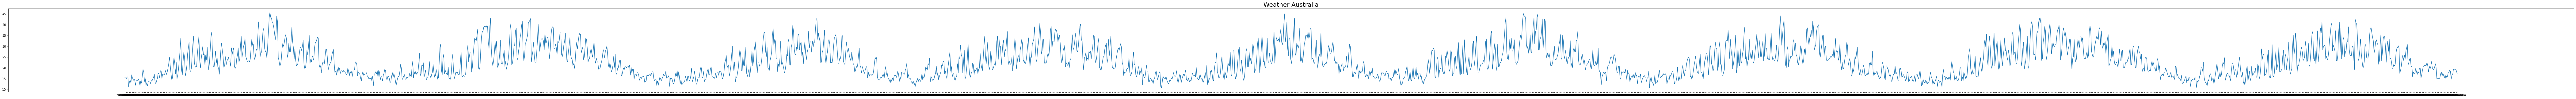

In [227]:
dates = df['Date'].values
temp  = df['MaxTemp'].values
 
 
plt.figure(figsize=(150,5))
plt.plot(dates, temp)
plt.title('Weather Australia',
          fontsize=20);

In [228]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [229]:
train_set = windowed_dataset(temp, window_size=30, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [230]:
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [231]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 1s 43ms/step - loss: 22.3178 - mae: 22.8178
Epoch 2/100
31/31 [==============================] - 1s 42ms/step - loss: 21.9570 - mae: 22.4570
Epoch 3/100
31/31 [==============================] - 1s 42ms/step - loss: 21.6200 - mae: 22.1200
Epoch 4/100
31/31 [==============================] - 1s 43ms/step - loss: 21.2131 - mae: 21.7131
Epoch 5/100
31/31 [==============================] - 1s 43ms/step - loss: 20.6679 - mae: 21.1679
Epoch 6/100
31/31 [====

In [245]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<=5):
      print("\nAkurasi telah mencapai 5% dari skala data!")
      self.model.stop_training = True
callbacks = myCallback()

In [246]:
history = model.fit(train_set,epochs=10,callbacks=[callbacks],verbose=2)

Epoch 1/10

Akurasi telah mencapai 5% dari skala data!
31/31 - 1s - loss: 2.9161 - mae: 3.3797


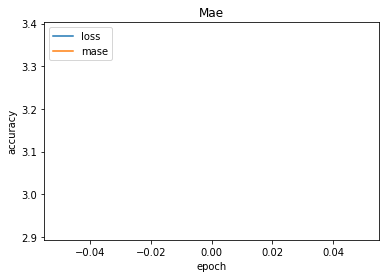

In [247]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])
plt.title('Mae')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'mase'], loc='upper left')
plt.show()